#### Importing the necessary libraries

In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics

#### importing the data

In [2]:
data = pd.read_csv("performance_export_2022-07-03.csv");

#### update the data to include the weekday number (0-6) and day name

In [3]:
data['timestamp'] = pd.to_datetime(data['timestamp'], format = '%Y/%m/%d %H:%M:%S')

data['daynumber'] = data['timestamp'].dt.weekday
data['dayname'] = data['timestamp'].dt.day_name()

In [5]:
tsmp_day = {} # dictionary that maps timestamps from 0 to 29 to the days
day_tsmp = {} # dictionary that maps days from 0 to 29 to the timestamps
for i, j in enumerate(np.sort(data.timestamp.unique())):
    tsmp_day[j] = i
    day_tsmp[i] = j

In [6]:
# data grouped by campaign and provider
df_cp = data.groupby(["campaign", "provider"])
# data grouped by campaign and metric
df_cm = data.groupby(["campaign", "metric"])
# data grouped by campaign, provider and metric
df_cpm = data.groupby(["campaign", "provider", "metric"])
# data grouped by provider and metric
df_pm = data.groupby(["provider", "metric"])

In [8]:
# parameters to run the loop
ncamp = data.campaign_id.unique().shape[0] # number of campaigns
nprov = data.provider.unique().shape[0] # number of providers
cname = data.campaign.unique() # all campaign names
pname = data.provider.unique() # all provider names

#### Let's plot metrics vs time in days to have an idea about patterns between metrics. 
#### Additionally, a linear regression lines for each metric could hel understand the behavior of metrics.

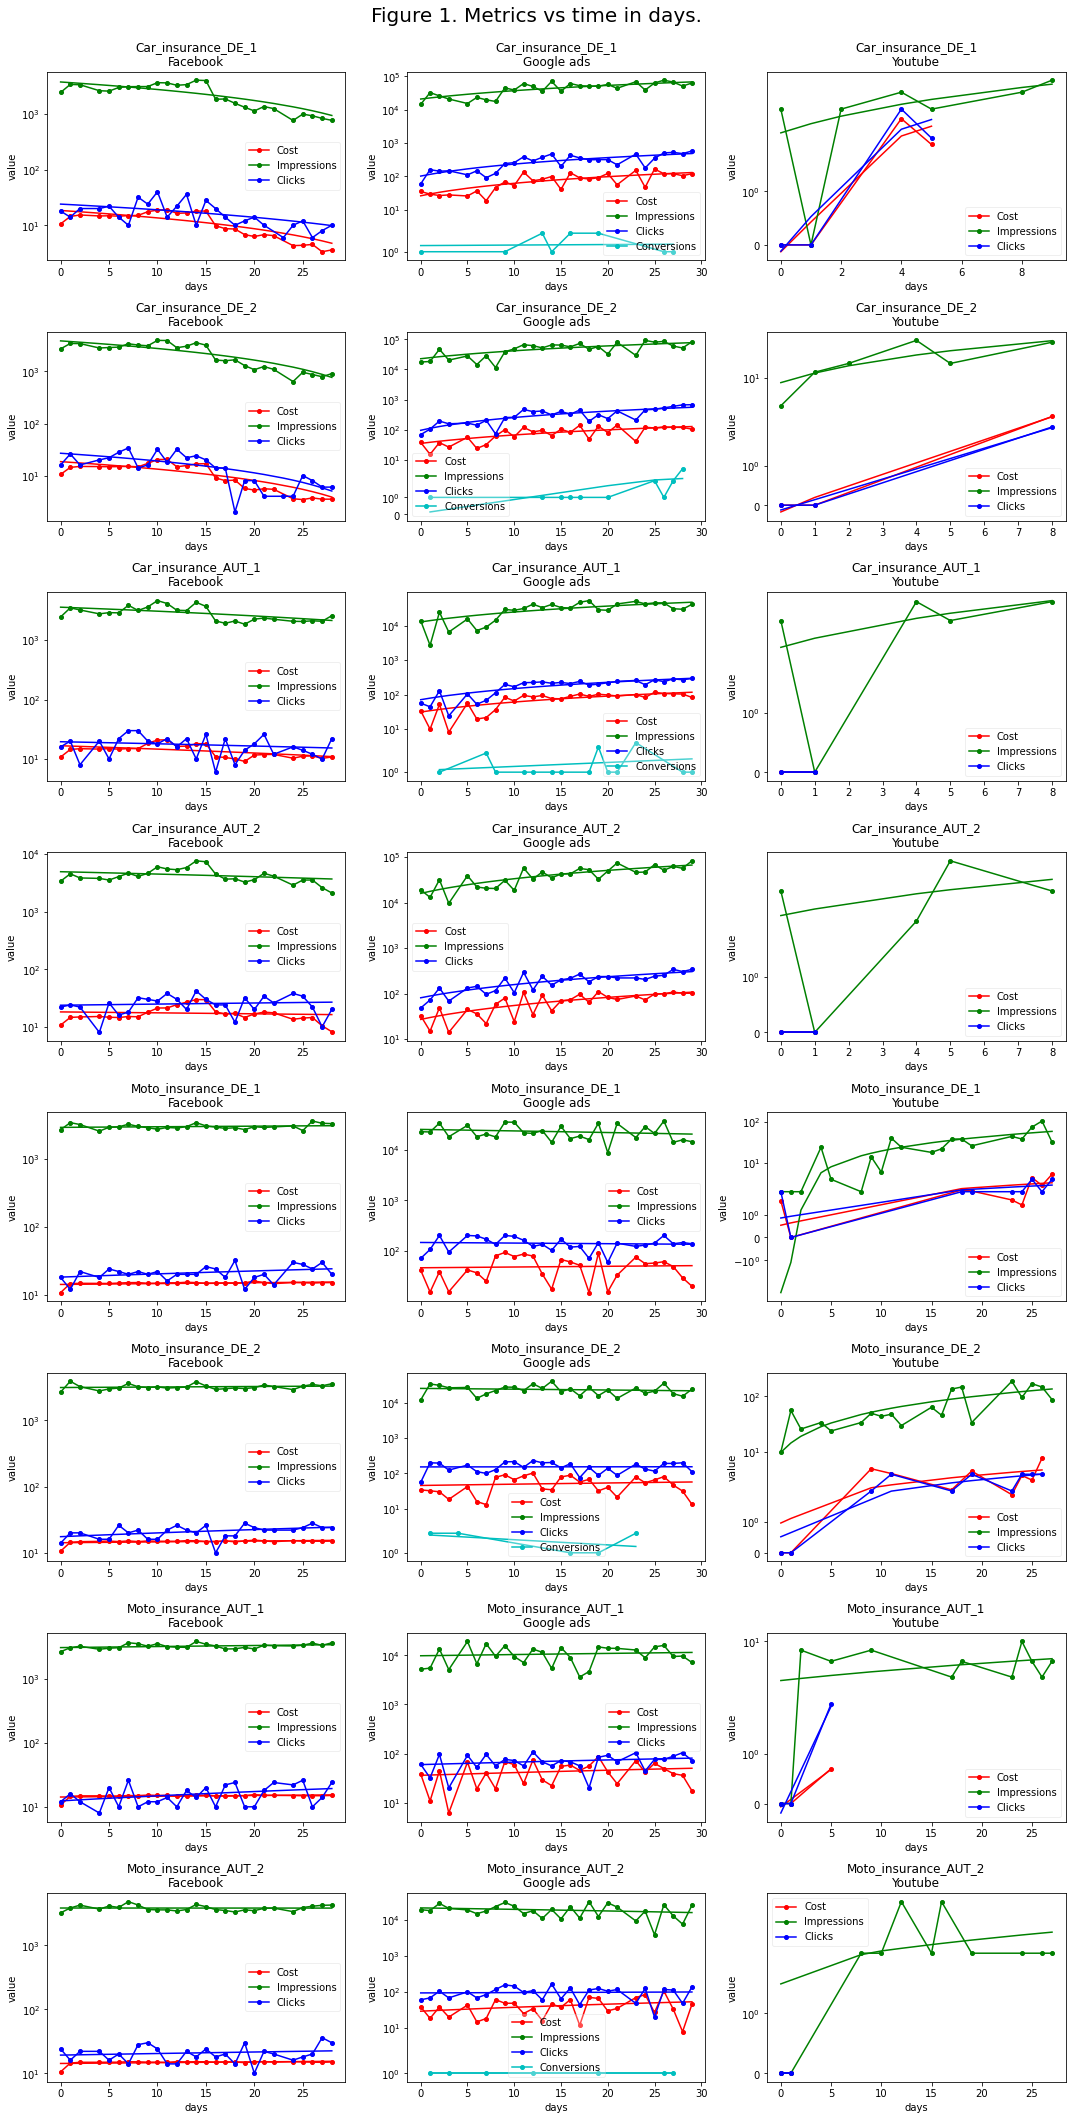

In [9]:
fig, axs = plt.subplots(ncamp, nprov, figsize=(15, 30))
fig.suptitle('Figure 1. Metrics vs time in days.', fontsize=20)
axs = axs.ravel()
k = 0 # counter for the figures
all_rmse = {} # all RMSE
all_coef = np.zeros((8,3)) # slope coefficients averaged over metrics
colors = {"Cost": "r", "Impressions": "g", "Clicks": "b", "Conversions": "c"}
best_camp = {}
for idx_c, elem_c in enumerate(cname):
    p_err = 0 # providers error
    for idx_p, elem_p in enumerate(pname):
        df = df_cp.get_group((elem_c, elem_p))
        m_err = 0 # metrics error
        m_coef_sum = 0 # sum for metric coefficients
        for m in df.metric.unique():
            df_plt = df_cpm.get_group((elem_c, elem_p, m))
            predictors = df_plt.timestamp.map(tsmp_day)
            outcome = df_plt.value
            model = LinearRegression()
            model.fit(predictors.to_numpy().reshape(-1,1), outcome.to_numpy())
            intercept = model.intercept_
            coef = model.coef_[0]
            # print(f'Intercept: {intercept}')
            # print(f'Coefficient : {coef}')
            fitted = model.predict(predictors.to_numpy().reshape(-1,1))
            rmse_p = np.sqrt(metrics.mean_squared_error(outcome.to_numpy(), fitted))
            # print(rmse_p)
            axs[k].plot(df_plt.timestamp.map(tsmp_day), df_plt.value, 'o-', ms = 4, label = m, color = colors[m])
            axs[k].plot(predictors, intercept + coef*predictors, color = colors[m])
            axs[k].set_yscale('symlog')
            axs[k].set_title(elem_c+"\n"+elem_p)
            axs[k].set_xlabel("days")
            axs[k].set_ylabel("value")
            axs[k].legend(loc='best', fancybox=True, framealpha=0.3)
            m_err += rmse_p
            m_coef_sum += coef
            if elem_c == "Moto_insurance_AUT_1" and elem_p == "Google ads":
                best_camp[m] = coef
        all_coef[idx_c, idx_p] = m_coef_sum/3
        p_err += m_err
        k += 1
    all_rmse[elem_c] = p_err
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig("MetricsVSTime.png")

#### Also, to have more insight we can plot running average of metrics vs time.

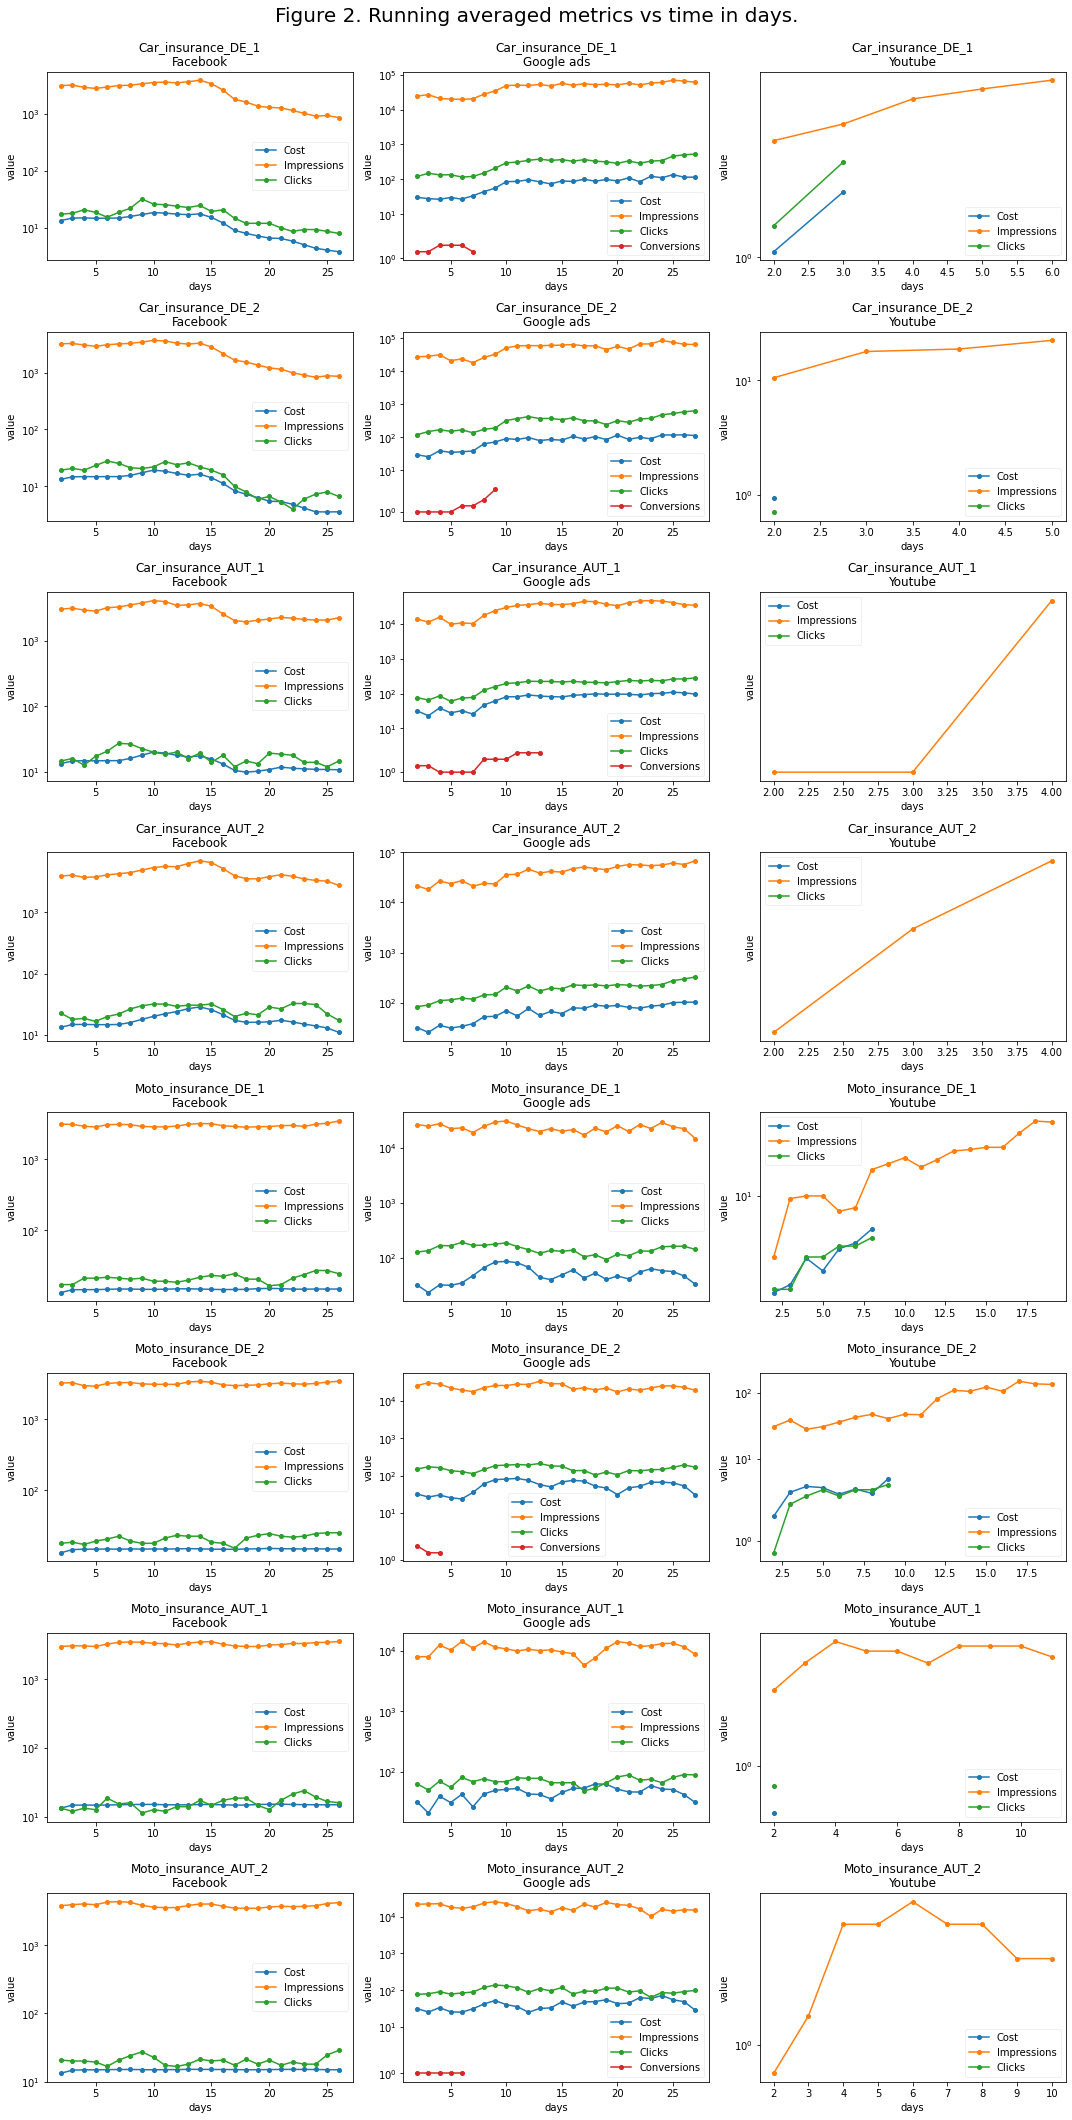

In [10]:
# Also, te have more insight we can plot running average of metrics vs time.
fig, axs = plt.subplots(ncamp, nprov, figsize=(15, 30))
fig.suptitle('Figure 2. Running averaged metrics vs time in days.', fontsize=20)
axs = axs.ravel()
k = 0 # counter for the figures
for elem_c in cname:
    for elem_p in pname:
        df = df_cp.get_group((elem_c, elem_p))
        for m in df.metric.unique():
            df_plt = df_cpm.get_group((elem_c, elem_p, m))
            val_aver = df_plt.value.rolling(window=3).mean()
            # if k == 0:
            #     print(val_aver.shape[0])
            axs[k].plot(range(val_aver.shape[0]), val_aver, 'o-', ms = 4, label = m)
            axs[k].set_yscale('symlog')
            axs[k].set_title(elem_c+"\n"+elem_p)
            axs[k].set_xlabel("days")
            axs[k].set_ylabel("value")
            axs[k].legend(loc='best', fancybox=True, framealpha=0.3)
        k += 1
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig("AverMetricsVSTime.png")

### Are there any patterns between the different metrics he is tracking? (e.g. x spending = y clicks? )

#### Judging by Figs. 1 and 2

1. Facebook: 
Just by judging the figures for **car insurances**, we can see a patterns (correlations) between **cost**, **impressions**, and **clicks** (particularly strong for car **cost** and **impressions**): the increment/decrease in one follows the other. It seems there is a correlation between clicks and cost for moto insurances too, but this could be confirmed by the evaluation of correlation coefficients. 

2. Google ads: 
Google ads, seems to outperform Facebook since stronger correlation can be seen between **cost**, **impressions** and **clicks** for car insurances. Also, **conversions** can be seen too for the first 3 car insurance campaigns which are absent for **Facebook** and **Youtube**. Moto insurances show correlation between **cost**, **impressions** and **clicks** as well but the **conversion** seems to be weakly correlated with other metrics. 

3. Youtube: 
There is no much data provided for **Youtube** compared to other providers, so it is hard to judge with less data. Nevertheless, figures show correlation between **cost** and **clicks** for 'Moto_insurance_DE_1' and 'Moto_insurance_DE_2' campaigns and for 'Moto_insurance_AUT_2', 'Car_insurance_AUT_2' and 'Car_insurance_AUT_1' campaigns only impressions are available, which means only brand awareness.

At this level of visualization, it seems that **Google ads** is the best provider, but let's evaluate the correlation coefficients.

In [11]:
# Evaluation of correlation coefficients
arr_CP = np.zeros((3,3,3,8)) # array for correlation matrices for each campaign and provider
count_c = 0 # counter for the campaigns
for elem_c in cname:
    count_p = 0 # counter for the providers
    for elem_p in pname:
        df = df_cp.get_group((elem_c, elem_p))
        df = df[df.metric != "Conversions"] # correlation only for 'Cost', 'Impressions', 'Clicks'
        df_time = pd.concat(g for _, g in df.groupby("timestamp") if len(g) > 1) # keeping entries with repeated timestamp
        df_time_piv = pd.pivot(df_time, index = "metric", columns = "timestamp", values = "value")
        corrmat = df_time_piv.T.corr() # correlation matrix (as a pandas dataframe)
        arr_CP[:, :, count_p, count_c] = corrmat.to_numpy()
        count_p += 1
        # count_f += 1
    count_c += 1

In [12]:
arr_F = arr_CP[:, :, 0, :] # correlation matrices for Facebook
arr_G = arr_CP[:, :, 1, :] # correlation matrices for Google ads
arr_Y = arr_CP[:, :, 2, :] # correlation matrices for Youtube

#### Lets see the correlation coefficients for different campaigns and providers

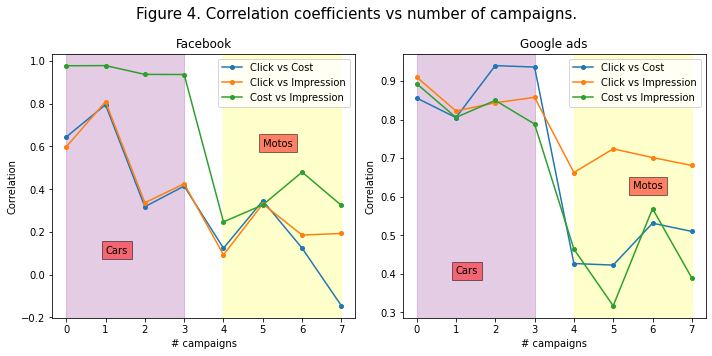

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Figure 4. Correlation coefficients vs number of campaigns.', fontsize=15)
axs[0].plot(range(8), arr_F[0, 1, :], 'o-', ms = 4, label = "Click vs Cost")
axs[0].plot(range(8), arr_F[0, 2, :], 'o-', ms = 4, label = "Click vs Impression")
axs[0].plot(range(8), arr_F[1, 2, :], 'o-', ms = 4, label = "Cost vs Impression")
axs[0].set_title("Facebook")
axs[0].set_xlabel("# campaigns")
axs[0].set_ylabel("Correlation")
axs[0].axvspan(0, 3, alpha=0.2, color='purple')
axs[0].axvspan(4, 7, alpha=0.2, color='yellow')
axs[0].text(1, 0.1, "Cars", bbox=dict(facecolor='red', alpha=0.5))
axs[0].text(5, 0.6, "Motos", bbox=dict(facecolor='red', alpha=0.5))
axs[0].legend()

axs[1].plot(range(8), arr_G[0, 1, :], 'o-', ms = 4, label = "Click vs Cost")
axs[1].plot(range(8), arr_G[0, 2, :], 'o-', ms = 4, label = "Click vs Impression")
axs[1].plot(range(8), arr_G[1, 2, :], 'o-', ms = 4, label = "Cost vs Impression")
axs[1].set_title("Google ads")
axs[1].set_xlabel("# campaigns")
axs[1].set_ylabel("Correlation")
axs[1].axvspan(0, 3, alpha=0.2, color='purple')
axs[1].axvspan(4, 7, alpha=0.2, color='yellow')
axs[1].text(1, 0.4, "Cars", bbox=dict(facecolor='red', alpha=0.5))
axs[1].text(5.5, 0.62, "Motos", bbox=dict(facecolor='red', alpha=0.5))
axs[1].legend()
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig("CorrVSCamp.png")

### Are there any patterns between the different metrics he is tracking? (e.g. x spending = y clicks? ) (continued)

Now, we can compare better the correlation coefficients of the metrics. 

1. **Facebook**: Fig. 4 shows that the strongest correlation is between **Cost** and **Impression** for car and moto campaigns. It is also confirmed by averaged correlation matrices: the last entry in the second column is **Cost** vs **Impression** correlation coefficient. It also shows that the correlation between metrics is stronger for car campaigns (the points in the **Cars** region are higher than in **Motos** region).

2. **Google ads**: We can see again from Figure 4 that for cars the correlation is bigger than for motos and from averaged correlation matrices we get that the **Click** vs **Impression** is the biggest. 

3. **Youtube**: it is hard to give good answer for Youtube since we cannot rely much on correlation matrices because of fewer data points as compared to Facebook and Google ads. But, at least, we can see from the first figure a strong correlation between **Cost** and **Click**.

#### Let's also see average values of the correlations for different providers

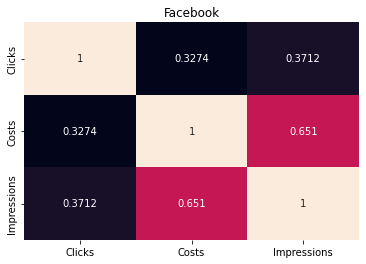

In [14]:
sns.heatmap(arr_F.mean(axis = -1), annot = True, cbar = False, fmt = '.4g', yticklabels = ["Clicks", "Costs", "Impressions"], xticklabels = ["Clicks", "Costs", "Impressions"]);
plt.title("Facebook")
plt.savefig("CorrFacebook.png")

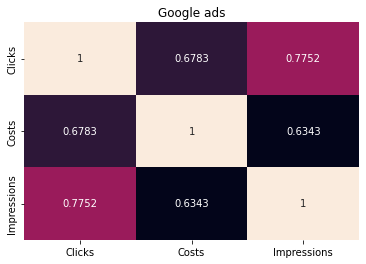

In [15]:
sns.heatmap(arr_G.mean(axis = -1), annot = True, cbar = False, fmt = '.4g', yticklabels = ["Clicks", "Costs", "Impressions"], xticklabels = ["Clicks", "Costs", "Impressions"]);
plt.title("Google ads")
plt.savefig("CorrGoogle.png")

#### The image below can help understand which provider gives average faster growth in metrics. 

#### It plots the slope coefficients averaged over metrics and campaigns for different providers

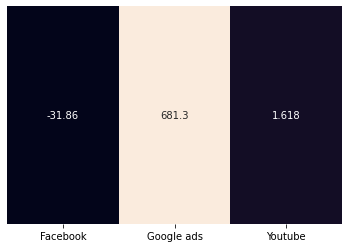

In [16]:
sns.heatmap((all_coef/3).sum(axis = 0).reshape(1,-1), annot = True, 
            cbar = False, fmt = '.4g', xticklabels = ["Facebook", "Google ads", "Youtube"],
           yticklabels = "");
plt.savefig("highest_slope.png")

### On which platform should he invest most of his marketing spending?

I would suggest Google ads, because of the following reasons: 

1. It is the only platform that generates **Conversion**. 
2. It shows the fastest growth in metrics, as shown in the above figure.
3. It shows the biggest values for the correlation coefficients averaged over all campaigns. In other words, their patterns are clear for Google ads.
4. **Click** vs. **Impression** correlation is the biggest of all metric correlations for Google ads. 
5. It showed an increase in the metric values over the days for car campaigns (see Figure 1). For **Facebook**, the growth is slower, and hence **Google ads** is preferable. The increase of metrics is observable for Youtube too, but with fewer data points. Also, for **Youtube**, only 'Moto_insurance_DE_1' and 'Moto_insurance_DE_2' campaigns showed correlated increase in **Clicks**, **Impressions** and **Cost**, while for **Google ads** it can be seen for all car campaigns plus **Conversions** are available.

### Is there a best day of the week to launch the new product?

In [17]:
for elem_p in pname:
    for m in data[data["provider"] == elem_p].metric.unique()[1:]:
        bets_day = df_pm.get_group((elem_p, m))[["value", "dayname"]].groupby(["dayname"]).sum().idxmax()[0]
        print(f"The best day for provider {elem_p} and metric {m} is", bets_day)

The best day for provider Facebook and metric Impressions is Tuesday
The best day for provider Facebook and metric Clicks is Tuesday
The best day for provider Google ads and metric Impressions is Monday
The best day for provider Google ads and metric Clicks is Saturday
The best day for provider Google ads and metric Conversions is Saturday
The best day for provider Youtube and metric Impressions is Friday
The best day for provider Youtube and metric Clicks is Friday


Overall, in terms of **impression, click and conversion**, the following days would be the best ones for running campaigns.

1. Facebook --> Tuesday,
2. Google ads --> Saturday
3. Youtube --> Friday

But, since the best provider is **Google ads** the best day would be **Saturday**. 

However, it also depends on the purpose of the ads and the buyer's journey. If we want to focus also on brand awareness, therefore, **Monday** would be another day to run campaigns since it generates high impressions.

As we see, the best days to run a new campaign are:

1. Facebook --> **Tuesday**,
2. Google ads --> **Saturday**
3. Youtube --> **Friday**

But, since the best provider is **Google ads** the best day overall could be **Saturday**. Nevertheless, if we think about the brand awareness, so we might as well choose **Monday** to better advertise the products.

### How has the performance of his campaigns developed over the past few months?

Currently, we see data taken for one month; therefore, let's see how the performance of the campaigns developed during this month.

1. Google ads 

Over the last days, car campaigns were performing the best. This is because we clearly see every time with an increase in **Cost**, the number of **Impressions** and **Clicks** goes up. Moreover, with the increase of **Impressions** the number of **Clicks** also went up (Figs. 1 and 2).

When it comes to the moto campaigns, the available data doesn't give deep insight whether there is positive or negative trend in metrics. However we see **Conversions**.


2. Facebook 

For the **"Cars"** campaigns, we have a decreasing trend. 
For the **"Moto"** campaign, the results do not change.

3. Youtube 

Although the **"Car"** campaigns have increasing metrics, we cannot give the same significance level as for **Google ads**, because of few data points.
Also, **cost**, **clicks** and **impressions** increase for **'Moto_insurance_DE_1'** and **'Moto_insurance_DE_2'** but not for all days - for the second half of the campagns only increased **Impressions** are available.

### 'Can we give him a forecast for one of those campaigns?

To answer this question, I suggest to find the RMSE for each metric, calculate the average of it over metrics, and then find the campaign with maximum averaged RMSE. Let's proceed.

In [18]:
all_rmse

{'Car_insurance_DE_1': 12358.252724230786,
 'Car_insurance_DE_2': 17239.595315763585,
 'Car_insurance_AUT_1': 10170.367584841051,
 'Car_insurance_AUT_2': 11958.099479278357,
 'Moto_insurance_DE_1': 7896.348383020106,
 'Moto_insurance_DE_2': 7638.5371974581285,
 'Moto_insurance_AUT_1': 4537.661649188414,
 'Moto_insurance_AUT_2': 7302.158436006324}

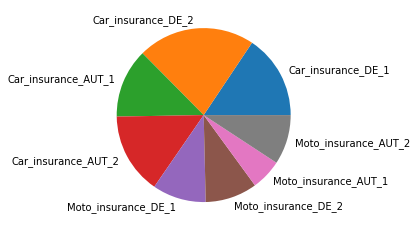

In [19]:
plt.pie(all_rmse.values(), labels = all_rmse.keys())
plt.savefig("Best_campaign.png")
plt.show();

As we can see, the smallest RMSE is for *Moto_insurance_AUT_1*, so a forecase can be given to this campaign. If we select, **Google ads** below are the slope coefficients of the metrics for that *Moto_insurance_AUT_1*.

**Cost**: 0.4863701840903012 

**Impressions**: 56.64669836420121 

**Clicks**: 0.7284024785869994 

This means, that the **Impressions** would increase by 57 per day and there would be on average 0.72 more clicks per day for that campaign.